### **ASSIGNMENT-3** ***continued***

It can be observed that the data is distributed unequally in each class. Also, in all the models used above, we can observe overfitting problem. So, to improve the accuracy, let's apply data augmentation.

Steps to follow:
<ol>1. Loading dataset and Preprocessing of data</ol>


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive/')

1. Loading Dataset and Preprocessing of data

In [1]:
import os
import keras
import tensorflow as tf
from keras.layers import Dense, GlobalAveragePooling2D
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from IPython.display import Image
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.applications import VGG16,ResNet50,InceptionV3
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
base_path='C:/Users/nivik/Downloads/plant-seedlings-classification'
train_file_path=os.path.join(base_path,'train/')
test_file_path=os.path.join(base_path,'test/')

In [3]:
#checking if the data in each folder is equal
def extraction(train_file_path):
    
    count=[]
    classes=os.listdir(train_file_path)
    for class_name in classes:
        class_path = os.path.join(train_file_path, class_name)
        count.append(len(os.listdir(class_path)))
        
    return classes,count

In [4]:
#extracting the class images and number of folders in it.
classes, count=extraction(train_file_path)

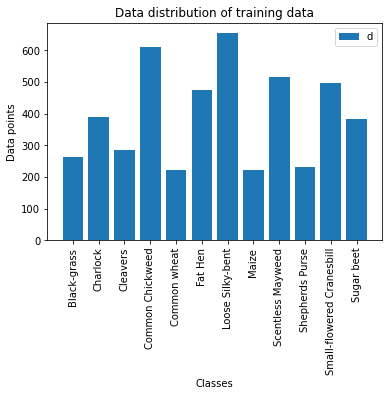

In [5]:
#data distribution of each class(Training data)
plt.bar(classes,count)
plt.xticks(range(12),labels=classes,rotation=90)
plt.xlabel("Classes")
plt.ylabel("Data points")
plt.legend("data")
plt.title("Data distribution of training data")
plt.show()

In [5]:
def data_augment(image):
    # Create an ImageDataGenerator for augmentation
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    sample = datagen.random_transform(image)
    return sample

In [6]:
#preparing data
def load_and_preprocess_data(train_file_path): 

    images_transformed = []
    labels_transformed = []
    
    #extracting the class names and the number of images in it
    classes, count=extraction(train_file_path)
    for class_name in classes:
        class_path = os.path.join(train_file_path, class_name) 

        desired_samples_per_class = max(count)
        num_samples=len(os.listdir(class_path))

        # Augment the data for underrepresented classes
        augment_factor = desired_samples_per_class // num_samples#it is factor to determine how many images are to be augmented

        images=[]
        labels=[]

        if os.path.isdir(class_path):
            for image_name in os.listdir(class_path):
                
                #Original images loading
                image = Image.open(os.path.join(class_path, image_name))
                image = image.resize((224,224)).convert('RGB')
                image = np.asarray(image)
                images.append(image)
                labels.append(class_name)

                #Augmenting the original data
                for i in range(augment_factor):
                    images.append(data_augment(image))
                    labels.append(class_name)
                
        #Shuffle the data
        images_shuffled, labels_shuffled = shuffle(images,labels)
        images_transformed.extend(images_shuffled[:desired_samples_per_class])
        labels_transformed.extend(labels_shuffled[:desired_samples_per_class])

    return np.array(images_transformed),np.array(labels_transformed)
    

In [7]:
# Normalize the images and apply one-hot encoding for labels
def preprocess_data(images, labels):
    
    images = images.astype('float') / 255.0
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)

    return images, labels

In [8]:
#loading  and preprocessing the training data 
final_images_d, final_labels_d = load_and_preprocess_data(train_file_path)
images_d, labels_d = preprocess_data(final_images_d, final_labels_d)

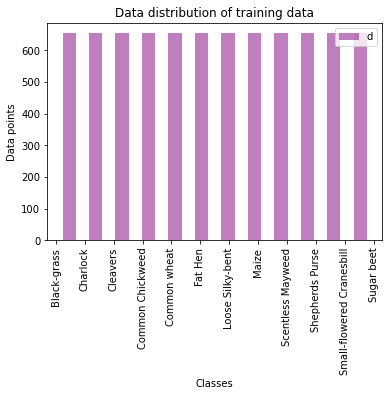

In [10]:
#data distribution of each class(Training data)
plt.hist(labels_d,bins=12,rwidth=0.5,alpha=0.5,color='purple')
plt.xticks(range(12),labels=classes,rotation=90)
plt.xlabel("Classes")
plt.ylabel("Data points")
plt.legend("data")
plt.title("Data distribution of training data")
plt.show()

In [9]:
images_shuffled_d, labels_shuffled_d=shuffle(images_d,labels_d)
#split the data to training and validing data
X_train_d, X_valid_d, y_train_d, y_valid_d = train_test_split(images_shuffled_d, labels_shuffled_d, test_size=0.2, random_state=0,shuffle=True)

#One-hot encoding
y_train_categorical_d=keras.utils.to_categorical(y_train_d,num_classes=12)
y_valid_categorical_d=keras.utils.to_categorical(y_valid_d,num_classes=12)

X_train_d.shape, X_valid_d.shape, y_train_categorical_d.shape, y_valid_categorical_d.shape

((6278, 224, 224, 3), (1570, 224, 224, 3), (6278, 12), (1570, 12))

Text(0.5, 0.98, 'Plant Seedling')

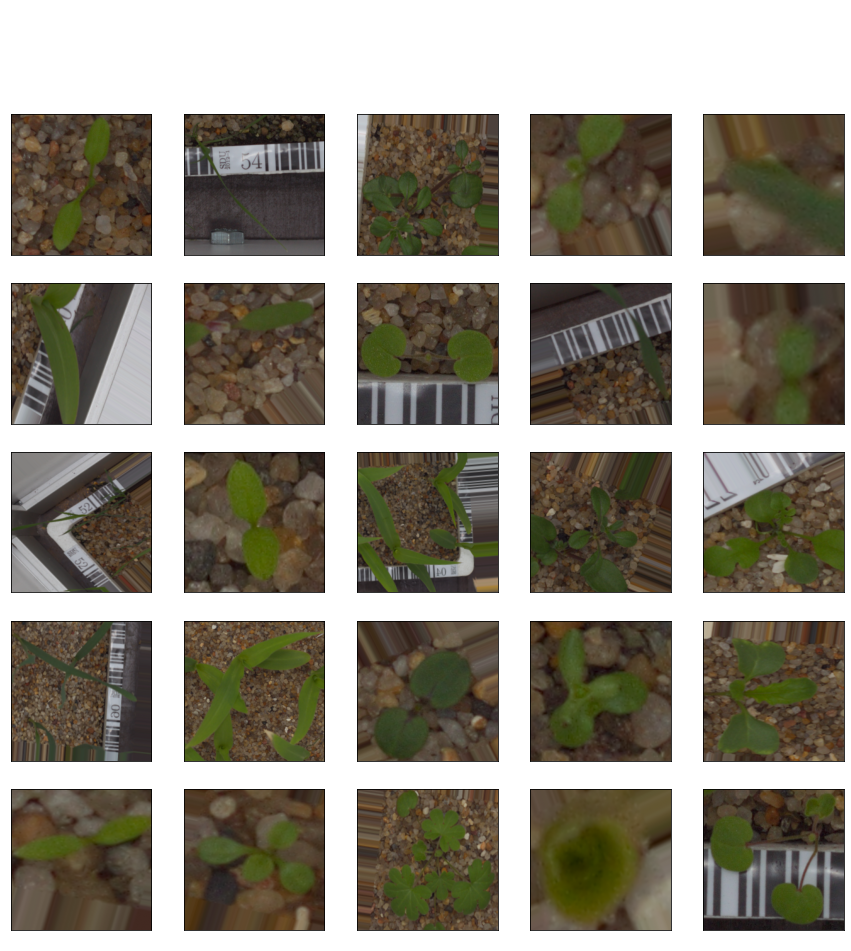

In [12]:
fig=plt.figure(figsize=(15,15))
for i in range(25):
    fig.add_subplot(5,5,i+1)
    plt.imshow(X_train_d[i],cmap=plt.cm.binary)
    plt.xticks([])
    plt.yticks([])
    plt.grid('off')
    predict=classes[np.argmax(y_train_categorical_d[i])]
    plt.xlabel(predict,color='white')
fig.suptitle("Plant Seedling",color='white')

2. Loading the customized pre-trained models

In [10]:
# Extract bottleneck features
def extract_bottleneck_features(data, base_model):
    bottleneck_features= base_model.predict(data)
    return bottleneck_features


# Plot Loss vs. Epochs
def plot_loss(history,title):
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Loss vs. Epochs - ' + title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
reduce_lr=keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=8,factor=0.2,min_lr=0.0001)

Model Training with transformed data

a. model_vgg (from VGG16)

In [13]:
# Load pre-trained VGG16 without top layers
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model_vgg.layers:
    layer.trainable=False
    
model_vgg_d=tf.keras.models.load_model('C:/Users/nivik/Downloads/plant-seedlings-classification/model_vgg.keras')
model_vgg_d.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 7, 7, 512)]       0         
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dropout (Dropout)           (None, 1024)              0     

In [16]:
  # Extract bottleneck features for training and testing data
bottleneck_features_train_vgg_d = extract_bottleneck_features(X_train_d, base_model_vgg)
bottleneck_features_valid_vgg_d = extract_bottleneck_features(X_valid_d, base_model_vgg)

50/50 [==============================] - 233s 5s/step


In [17]:
# Compile and train the model
model_vgg_d.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_vgg_d = model_vgg_d.fit(bottleneck_features_train_vgg_d, y_train_categorical_d, epochs=20, validation_split=0.1,callbacks=[reduce_lr])

Epoch 1/20
177/177 [==============================] - 2s 7ms/step - loss: 1.0662 - accuracy: 0.6821 - val_loss: 0.7544 - val_accuracy: 0.7404 - lr: 0.0010
Epoch 2/20
177/177 [==============================] - 1s 6ms/step - loss: 0.7411 - accuracy: 0.7496 - val_loss: 0.7419 - val_accuracy: 0.7373 - lr: 0.0010
Epoch 3/20
177/177 [==============================] - 1s 6ms/step - loss: 0.5980 - accuracy: 0.7972 - val_loss: 0.6851 - val_accuracy: 0.7787 - lr: 0.0010
Epoch 4/20
177/177 [==============================] - 1s 6ms/step - loss: 0.5649 - accuracy: 0.8051 - val_loss: 0.7451 - val_accuracy: 0.7611 - lr: 0.0010
Epoch 5/20
177/177 [==============================] - 1s 8ms/step - loss: 0.5198 - accuracy: 0.8181 - val_loss: 0.8473 - val_accuracy: 0.7118 - lr: 0.0010
Epoch 6/20
177/177 [==============================] - 2s 9ms/step - loss: 0.4656 - accuracy: 0.8382 - val_loss: 0.7053 - val_accuracy: 0.7643 - lr: 0.0010
Epoch 7/20
177/177 [==============================] - 1s 8ms/step - lo

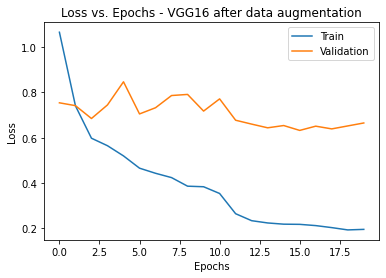

In [18]:
#plot loss vs epochs
plot_loss(history_vgg_d,"VGG16 after data augmentation")

In [19]:
#Evaluation
vgg_evaluate_d=model_vgg_d.evaluate(bottleneck_features_valid_vgg_d,y_valid_categorical_d)
vgg_evaluate_d

50/50 [==============================] - 0s 4ms/step - loss: 0.7510 - accuracy: 0.7764


[0.7509640455245972, 0.7764331102371216]

50/50 [==============================] - 0s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.66      0.67       129
           1       0.83      0.90      0.86       131
           2       0.82      0.79      0.80       143
           3       0.81      0.82      0.81       121
           4       0.78      0.81      0.79       134
           5       0.71      0.77      0.74       129
           6       0.68      0.73      0.70       146
           7       0.85      0.87      0.86       150
           8       0.76      0.64      0.69       135
           9       0.72      0.70      0.71       125
          10       0.84      0.87      0.85       117
          11       0.87      0.77      0.82       110

    accuracy                           0.78      1570
   macro avg       0.78      0.78      0.78      1570
weighted avg       0.78      0.78      0.78      1570

Confusion Matrix:
Confusion Matrix:


Text(159.0, 0.5, 'Predict')

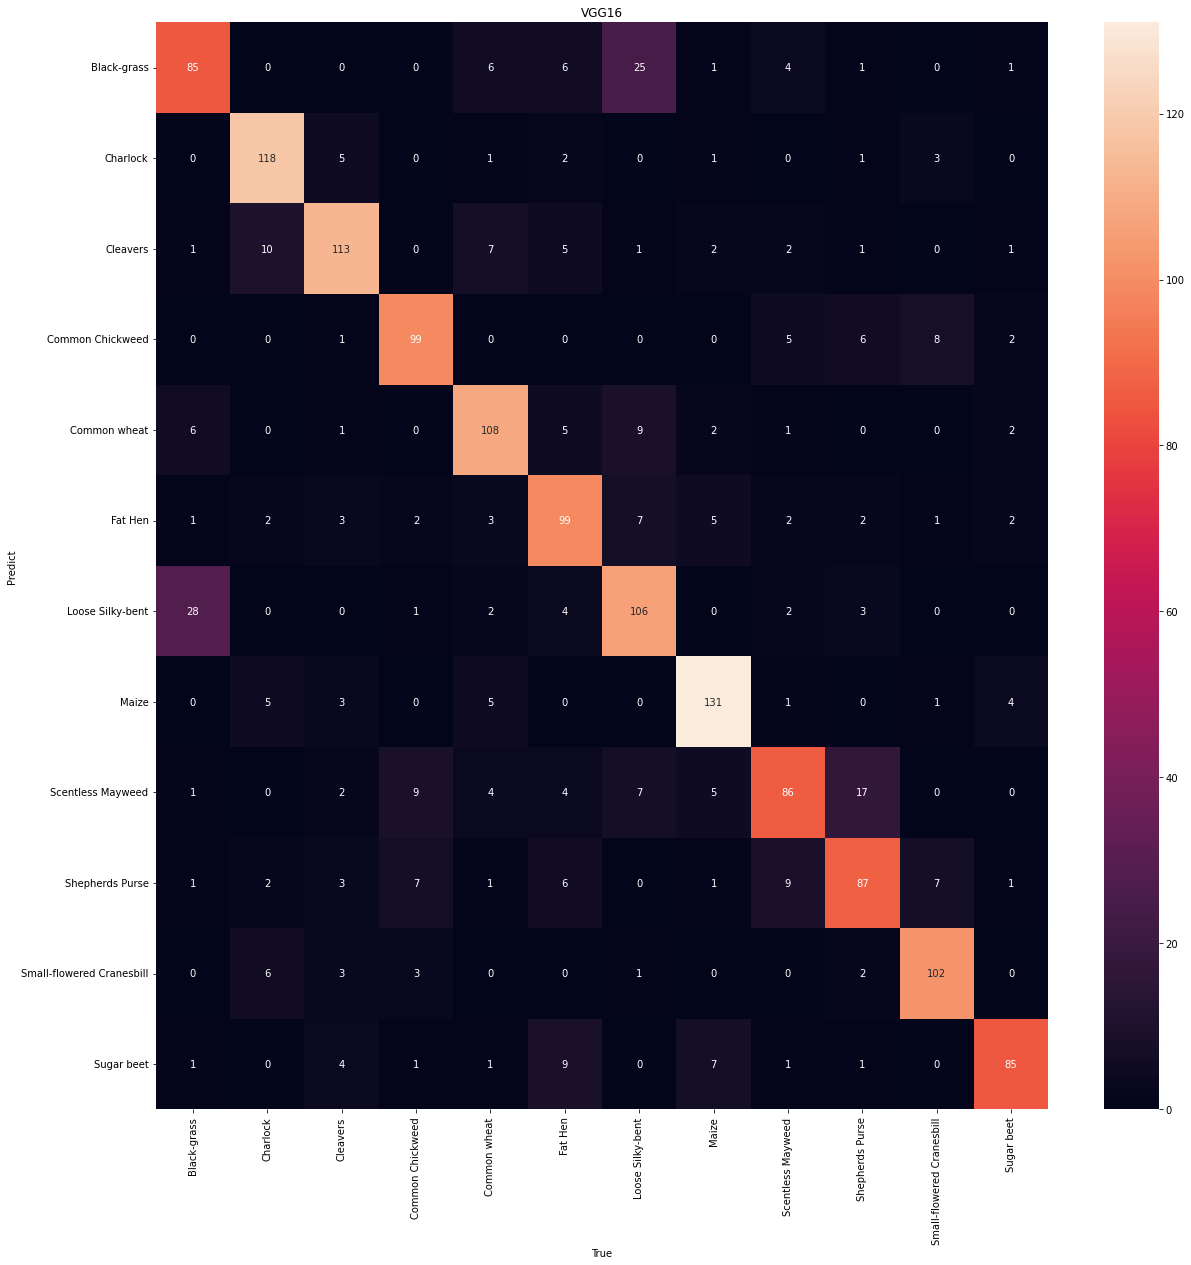

In [20]:
# Generate classification report and confusion matrix
y_pred = model_vgg_d.predict(bottleneck_features_valid_vgg_d)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_valid_categorical_d, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

print("Confusion Matrix:")
print("Confusion Matrix:")
cm2=confusion_matrix(y_true,y_pred_classes)
plt.figure(figsize=(20,20))
ax1=sn.heatmap(cm2,annot=True,fmt='g')
ax1.set_xticklabels(list(classes),rotation=90)
ax1.set_yticklabels(list(classes),rotation=0)
plt.title("VGG16")
plt.xlabel("True")
plt.ylabel("Predict")

In [21]:
#save model
model_vgg_d.save('C:/Users/nivik/Downloads/plant-seedlings-classification/model_vgg_d.keras')

b. model_res (from ResNet50)

In [26]:
# Load pre-trained Resnet50 without top layers
base_model_res = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model_res.layers:
    layer.trainable=False
    
model_res_d=tf.keras.models.load_model('C:/Users/nivik/Downloads/plant-seedlings-classification/model_res.keras')
model_res_d.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 7, 7, 2048)]      0         
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_1 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0   

In [13]:
# Extract bottleneck features for training and testing data
bottleneck_features_train_res_d = extract_bottleneck_features(keras.applications.resnet.preprocess_input(X_train_d), base_model_res)
bottleneck_features_valid_res_d = extract_bottleneck_features(keras.applications.resnet.preprocess_input(X_valid_d), base_model_res)

50/50 [==============================] - 90s 2s/step


In [27]:
# Compile and train the model
model_res_d.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history_res_d = model_res_d.fit(bottleneck_features_train_res_d, y_train_categorical_d, epochs=20, validation_split=0.1,callbacks=[reduce_lr])

Epoch 1/20
177/177 [==============================] - 4s 18ms/step - loss: 1.0029 - accuracy: 0.6828 - val_loss: 0.8545 - val_accuracy: 0.7357 - lr: 1.0000e-04
Epoch 2/20
177/177 [==============================] - 3s 17ms/step - loss: 0.6025 - accuracy: 0.7949 - val_loss: 0.7788 - val_accuracy: 0.7564 - lr: 1.0000e-04
Epoch 3/20
177/177 [==============================] - 3s 17ms/step - loss: 0.4478 - accuracy: 0.8432 - val_loss: 0.7325 - val_accuracy: 0.7771 - lr: 1.0000e-04
Epoch 4/20
177/177 [==============================] - 3s 17ms/step - loss: 0.3375 - accuracy: 0.8887 - val_loss: 0.6844 - val_accuracy: 0.7866 - lr: 1.0000e-04
Epoch 5/20
177/177 [==============================] - 3s 18ms/step - loss: 0.2610 - accuracy: 0.9175 - val_loss: 0.6743 - val_accuracy: 0.7818 - lr: 1.0000e-04
Epoch 6/20
177/177 [==============================] - 4s 20ms/step - loss: 0.2017 - accuracy: 0.9400 - val_loss: 0.6897 - val_accuracy: 0.7834 - lr: 1.0000e-04
Epoch 7/20
177/177 [====================

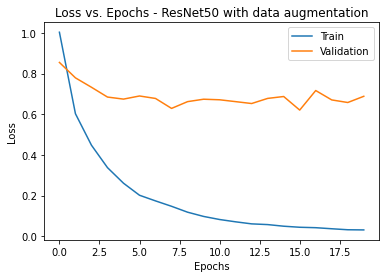

In [28]:
#plot loss vs epochs
plot_loss(history_res_d,"ResNet50 with data augmentation")

In [29]:
#Evaluation
res_evaluate_d=model_res_d.evaluate(bottleneck_features_valid_res_d,y_valid_categorical_d)
res_evaluate_d

50/50 [==============================] - 0s 4ms/step - loss: 2.7439 - accuracy: 0.6478


[2.743943691253662, 0.6477707028388977]

50/50 [==============================] - 0s 5ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.53      0.59       117
           1       0.73      0.89      0.80       116
           2       0.44      0.94      0.60       117
           3       0.47      0.92      0.62       137
           4       0.94      0.40      0.56       146
           5       0.50      0.82      0.62       125
           6       0.80      0.30      0.44       145
           7       0.98      0.57      0.72       142
           8       0.82      0.60      0.69       131
           9       0.93      0.48      0.64       143
          10       0.87      0.84      0.85       129
          11       0.64      0.61      0.63       122

    accuracy                           0.65      1570
   macro avg       0.73      0.66      0.65      1570
weighted avg       0.74      0.65      0.64      1570

Confusion Matrix:


Text(159.0, 0.5, 'Predict')

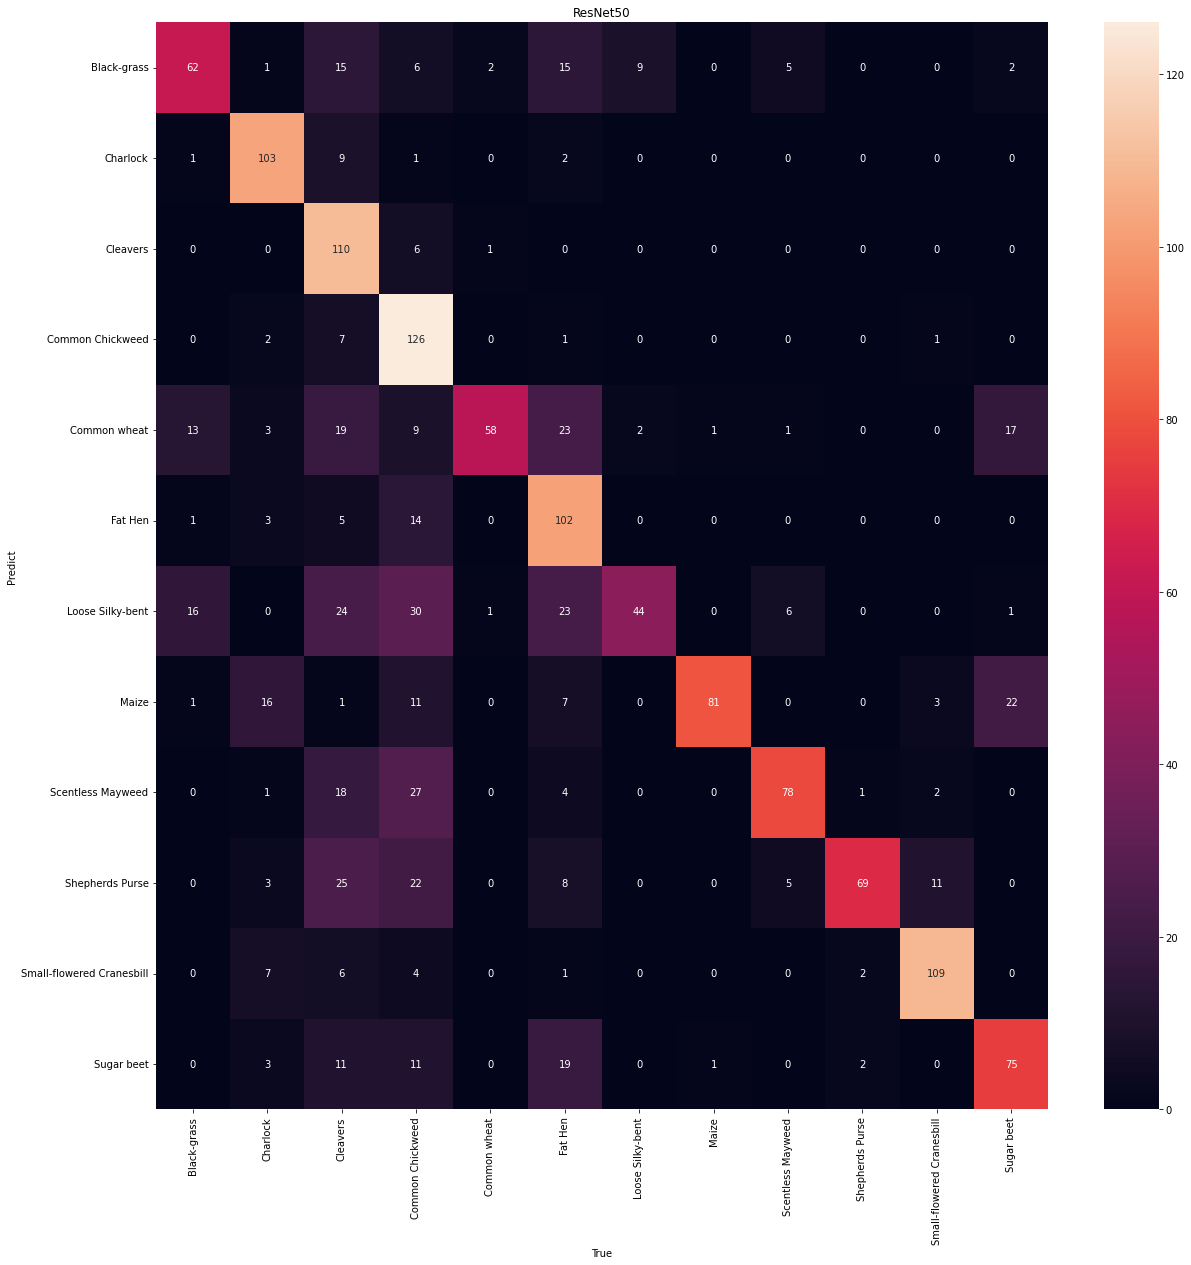

In [30]:
# Generate classification report and confusion matrix
y_pred = model_res_d.predict(bottleneck_features_valid_res_d)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_valid_categorical_d, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

print("Confusion Matrix:")
cm2=confusion_matrix(y_true,y_pred_classes)
plt.figure(figsize=(20,20))
ax1=sn.heatmap(cm2,annot=True,fmt='g')
ax1.set_xticklabels(list(classes),rotation=90)
ax1.set_yticklabels(list(classes),rotation=0)
plt.title("ResNet50")
plt.xlabel("True")
plt.ylabel("Predict")

In [31]:
#save model
model_res_d.save('C:/Users/nivik/Downloads/plant-seedlings-classification/model_res_d.keras')

c. model_incep (from Inceptionv3)

In [19]:
# Load pre-trained InceptionV3 without top layers
base_model_incep = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model_incep.layers:
    layer.trainable=False
    
model_incep_d=tf.keras.models.load_model('C:/Users/nivik/Downloads/plant-seedlings-classification/model_incep.keras')
model_incep_d.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 5, 5, 2048)]      0         
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_96 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0   

In [13]:
# Extract bottleneck features for training and testing data
bottleneck_features_train_incep_d = extract_bottleneck_features(X_train_d, base_model_incep)
bottleneck_features_valid_incep_d = extract_bottleneck_features(X_valid_d, base_model_incep)

50/50 [==============================] - 62s 1s/step


In [20]:
# Compile and train the model
model_incep_d.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history_incep_d = model_incep_d.fit(bottleneck_features_train_incep_d, y_train_categorical_d, epochs=20, validation_split=0.1,callbacks=[reduce_lr])

Epoch 1/20
177/177 [==============================] - 5s 23ms/step - loss: 0.7227 - accuracy: 0.8012 - val_loss: 0.5695 - val_accuracy: 0.8487 - lr: 1.0000e-04
Epoch 2/20
177/177 [==============================] - 4s 24ms/step - loss: 0.4016 - accuracy: 0.8664 - val_loss: 0.5554 - val_accuracy: 0.8424 - lr: 1.0000e-04
Epoch 3/20
177/177 [==============================] - 5s 31ms/step - loss: 0.2498 - accuracy: 0.9173 - val_loss: 0.5272 - val_accuracy: 0.8519 - lr: 1.0000e-04
Epoch 4/20
177/177 [==============================] - 7s 38ms/step - loss: 0.1759 - accuracy: 0.9411 - val_loss: 0.5105 - val_accuracy: 0.8519 - lr: 1.0000e-04
Epoch 5/20
177/177 [==============================] - 6s 32ms/step - loss: 0.1255 - accuracy: 0.9609 - val_loss: 0.5158 - val_accuracy: 0.8551 - lr: 1.0000e-04
Epoch 6/20
177/177 [==============================] - 6s 31ms/step - loss: 0.0910 - accuracy: 0.9743 - val_loss: 0.5281 - val_accuracy: 0.8471 - lr: 1.0000e-04
Epoch 7/20
177/177 [====================

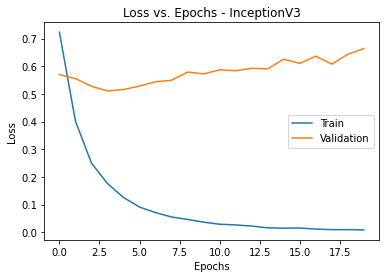

In [21]:
#plot loss vs epochs
plot_loss(history_incep_d,"InceptionV3")

In [22]:
#Evaluation
incep_evaluate_d=model_incep_d.evaluate(bottleneck_features_valid_incep_d,y_valid_categorical_d)
incep_evaluate_d

 1/50 [..............................] - ETA: 1s - loss: 0.7922 - accuracy: 0.8125

50/50 [==============================] - 0s 5ms/step - loss: 0.5542 - accuracy: 0.8522


[0.5542268753051758, 0.8522292971611023]

50/50 [==============================] - 0s 5ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.68      0.74       124
           1       0.90      0.95      0.92       131
           2       0.90      0.88      0.89       121
           3       0.88      0.78      0.83       148
           4       0.78      0.90      0.83       116
           5       0.89      0.82      0.86       144
           6       0.71      0.85      0.77       128
           7       0.97      0.98      0.97       113
           8       0.83      0.83      0.83       139
           9       0.79      0.79      0.79       132
          10       0.87      0.90      0.88       139
          11       0.93      0.90      0.91       135

    accuracy                           0.85      1570
   macro avg       0.86      0.85      0.85      1570
weighted avg       0.86      0.85      0.85      1570

Confusion Matrix:
Confusion Matrix:


Text(159.0, 0.5, 'Predict')

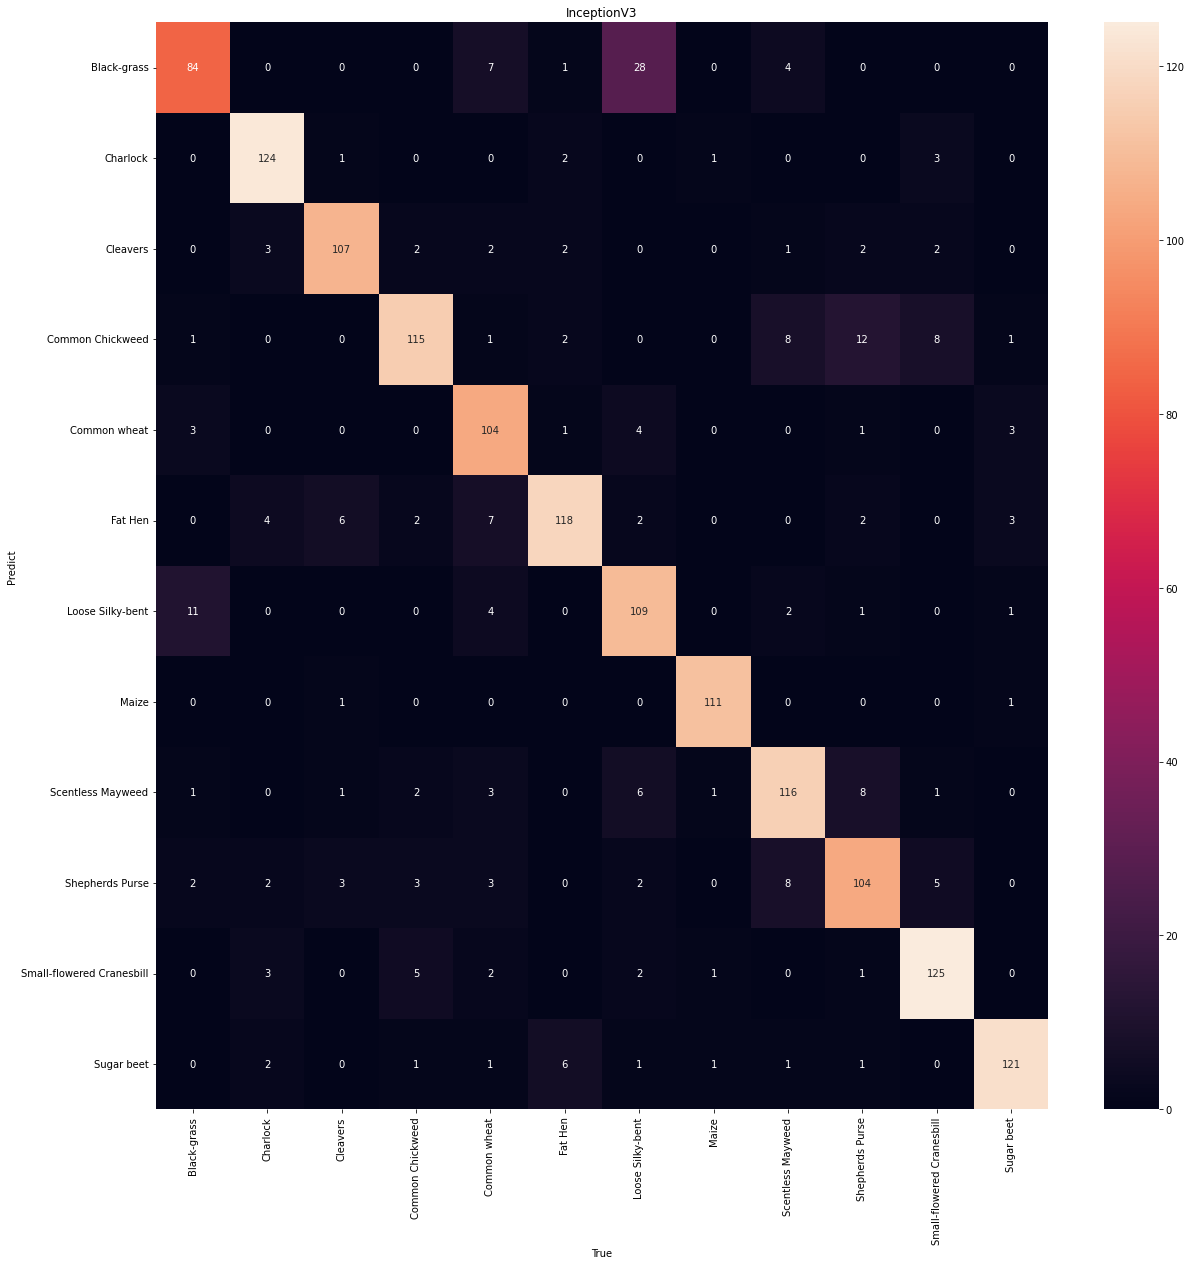

In [23]:
# Generate classification report and confusion matrix
y_pred = model_incep_d.predict(bottleneck_features_valid_incep_d)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_valid_categorical_d, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

print("Confusion Matrix:")
print("Confusion Matrix:")
cm2=confusion_matrix(y_true,y_pred_classes)
plt.figure(figsize=(20,20))
ax1=sn.heatmap(cm2,annot=True,fmt='g')
ax1.set_xticklabels(list(classes),rotation=90)
ax1.set_yticklabels(list(classes),rotation=0)
plt.title("InceptionV3")
plt.xlabel("True")
plt.ylabel("Predict")

In [24]:
#save model
model_incep_d.save('C:/Users/nivik/Downloads/plant-seedlings-classification/model_incep_d.keras')

After data augmentation is applied,
<ul> MODEL------------------ACCURACY</ul>
<ul> VGG16------------------77.64%</ul>
<ul> ResNet50---------------64.77%</ul>
<ul> InceptionV3------------85.22%</ul>